In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import cv2
from load_dataset import load_standardised_dataset
from image_standardisation import restore_standardised_image

In [2]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

Code stolen from:
https://github.com/VidushiBhatia/U-Net-Implementation/blob/main/U_Net_for_Image_Segmentation_From_Scratch_Using_TensorFlow_v4.ipynb

In [3]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning. 
    Dropout can be added for regularization to prevent overfitting. 
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow 
    # Proper initialization prevents from the problem of exploding and vanishing gradients 
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size) 
    conv = layers.Conv2D(n_filters, 
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = layers.Conv2D(n_filters, 
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    
    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    # conv = layers.BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions      
    skip_connection = conv
    
    return next_layer, skip_connection

In [4]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = layers.Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = layers.concatenate([up, skip_layer_input], axis=3)
    
    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = layers.Conv2D(n_filters, 
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = layers.Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

In [5]:
def UNetCompiled(input_size=(256, 256, 3), n_filters=32, n_classes=3):
    """
    Combine both encoder and decoder blocks according to the U-Net research paper
    Return the model as output 
    """
    # Input size represent the size of 1 image (the size used for pre-processing) 
    inputs = tf.keras.Input(input_size)

    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=False)
    # cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=False)
    # cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=False)
    # cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0, max_pooling=False)
    # cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 

    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    # ublock6 = DecoderMiniBlock(cblock4[0], cblock3[1],  n_filters * 8)
    # ublock7 = DecoderMiniBlock(cblock3[0], cblock2[1],  n_filters * 4)
    # ublock8 = DecoderMiniBlock(cblock2[0], cblock1[1],  n_filters * 2)
    # ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size. 
    # Observe the number of channels will be equal to number of output classes
    conv9 = layers.Conv2D(n_filters,
                    3,
                    activation='relu',
                    padding='same',
                    kernel_initializer='he_normal')(cblock1[0])

    conv10 = layers.Conv2D(n_classes, 1, padding='same')(conv9)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [6]:
# Call the helper function for defining the layers for the model, given the input image size
unet = UNetCompiled(input_size=(256,256,3), n_filters=32, n_classes=3)

In [7]:
unet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 3)       99        
                                                                 
Total params: 19,491
Trainable params: 19,491
Non-trainable params: 0
_________________________________________________________________


In [10]:
# There are multiple optimizers, loss functions and metrics that can be used to compile multi-class segmentation models
# Ideally, try different options to get the best accuracy
unet.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [9]:
np.random.seed(256)
path_to_dataset = Path("../SIDD_Small_sliced/Data/")
TRAIN_PAIRS_TO_LOAD = 1000
TEST_PAIRS_TO_LOAD = TRAIN_PAIRS_TO_LOAD//8
VAL_PAIRS_TO_LOAD = TRAIN_PAIRS_TO_LOAD//8
train_x, train_y, test_x, test_y, val_x, val_y = load_standardised_dataset(str(path_to_dataset), TRAIN_PAIRS_TO_LOAD, TEST_PAIRS_TO_LOAD, VAL_PAIRS_TO_LOAD)

In [11]:
early = EarlyStopping(patience=3, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='loss', patience=2)

In [12]:
# learn how to plot training history
history = unet.fit(train_x, train_y,
                epochs=10,
                shuffle=True,
                validation_data=(val_x, val_y),
                callbacks=[early, reduce])

Epoch 1/10
32/32 [==============================] - 8s 164ms/step - loss: 0.0307 - val_loss: 0.0064 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 4s 131ms/step - loss: 0.0050 - val_loss: 0.0035 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 4s 131ms/step - loss: 0.0032 - val_loss: 0.0025 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 4s 131ms/step - loss: 0.0023 - val_loss: 0.0019 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 4s 132ms/step - loss: 0.0019 - val_loss: 0.0016 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 4s 132ms/step - loss: 0.0016 - val_loss: 0.0014 - lr: 0.0010
Epoch 7/10
32/32 [==============================] - 4s 133ms/step - loss: 0.0014 - val_loss: 0.0013 - lr: 0.0010
Epoch 8/10
32/32 [==============================] - 4s 133ms/step - loss: 0.0013 - val_loss: 0.0012 - lr: 0.0010
Epoch 9/10
32/32 [==============================] - 4s 136ms/step - loss: 0.0012 - val_loss: 0.0

In [13]:
# encoded_imgs = autoencoder.encoder(test_x).numpy()
# decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
decoded_imgs = unet(test_x).numpy()

ResourceExhaustedError: Exception encountered when calling layer "conv2d" "                 f"(type Conv2D).

{{function_node __wrapped__Conv2D_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[125,32,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

Call arguments received by layer "conv2d" "                 f"(type Conv2D):
  • inputs=tf.Tensor(shape=(125, 256, 256, 3), dtype=float32)

In [10]:
print(decoded_imgs[0][100][0], test_x[0][0][0])

[-0.30393383 -0.37748113 -0.30150256] [-0.48334622 -0.32843137 -0.20060998]


In [11]:
rgb_decoded_imgs = np.array([restore_standardised_image(img) for img in decoded_imgs])

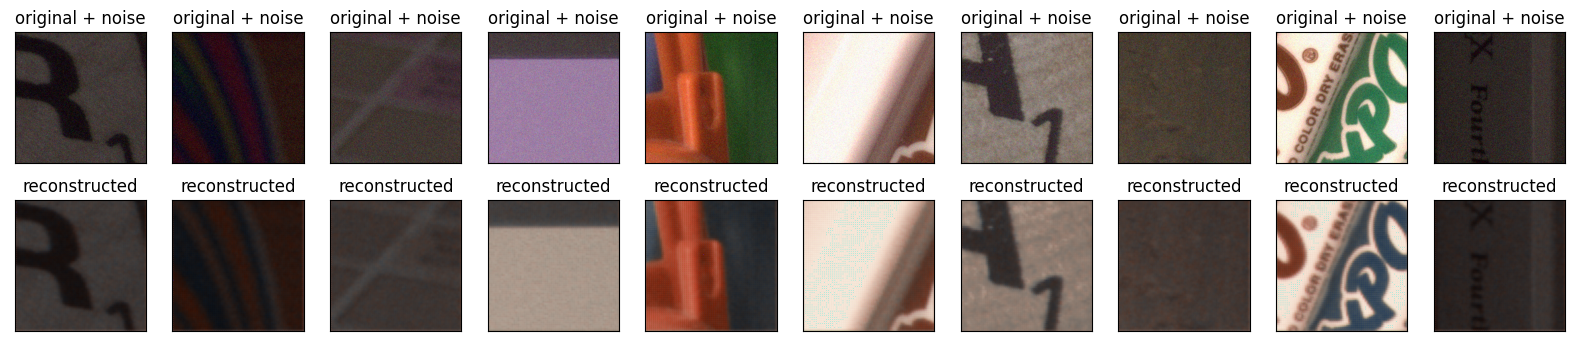

In [12]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(restore_standardised_image(test_x[i])))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(rgb_decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()
